In [6]:
CLEANED_TRAIN_DATA_PATH = "../../data/processed/cleaned_train_data.pkl"
PREPROC_DATA_PATH = "../../data/processed/"

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from genetic_selection import GeneticSelectionCV

# Import imputing features methods


# Import features selection methods
from sklearn.feature_selection import (
    mutual_info_classif,
    SelectKBest,
    SelectFromModel,
)


from mlxtend.feature_selection import SequentialFeatureSelector as mlx_sfs



# Import tunning hypter parameters methods
from sklearn.model_selection import GridSearchCV

# from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


# Import resambling methods
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

import warnings

warnings.filterwarnings("ignore")


In [8]:
# Change some pandas display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.width", 1000)
pd.set_option("styler.format.precision", 10)


# Read Data

In [10]:
df_train = pd.read_pickle(CLEANED_TRAIN_DATA_PATH)

num_cols = [
    "age",
    "resting_blood_pressure",
    "serum_cholestoral",
    "maximum_heart_rate",
    "ST_depression",
]
cat_cols = set(df_train.columns.to_list()) - set(num_cols)
cat_cols = list(cat_cols)

X = df_train.iloc[:, :-1]
y = df_train["target"]



In [11]:
pipe = Pipeline(
    [
        (
            "reduce_dim",
            "passthrough",
        ),  # the reduce_dim stage is populated by the param_grid
        ("ros_resambling", RandomOverSampler()),
        # ("smote_resampling", SMOTE(random_state=42)),
        ("estimator", RandomForestClassifier()),
    ]
)

N_FEATURES_OPTIONS = [6, 7, 8, 9]
N_NEIGHBORS_OPTIONS = [3, 5, 7]
N_TREES_OPTIONS = [60, 80, 100, 120]

param_grid = [
    {
        "reduce_dim": [SelectFromModel(DecisionTreeClassifier(criterion="gini"))],
        "reduce_dim__max_features": N_FEATURES_OPTIONS,
        # "smote_resampling__k_neighbors": N_NEIGHBORS_OPTIONS,
        "estimator__n_estimators": N_TREES_OPTIONS,
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        # "reduce_dim__score_func__n_neighbors": N_NEIGHBORS_OPTIONS,
        # "smote_resampling__k_neighbors": N_NEIGHBORS_OPTIONS,
        "estimator__n_estimators": N_TREES_OPTIONS,
    },
    {
        "reduce_dim": [SelectFromModel(DecisionTreeClassifier(criterion="entropy"))],
        "reduce_dim__max_features": N_FEATURES_OPTIONS,
        # "smote_resampling__k_neighbors": N_NEIGHBORS_OPTIONS,
        "estimator__n_estimators": N_TREES_OPTIONS,
    },
]
reducer_labels = ["PCA", "NMF", "KBest(mutual_info_classif)"]
scoring = {
    "accuracy": "balanced_accuracy",
    "f1": "f1_macro",
    "ROC_AUC": "roc_auc_ovo_weighted",
}

grid = GridSearchCV(
    pipe,
    n_jobs=-1,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",
    verbose=2,
    return_train_score=True,
)
grid.fit(X, y)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=Pipeline(steps=[('reduce_dim', 'passthrough'),
                                       ('ros_resambling', RandomOverSampler()),
                                       ('estimator',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'estimator__n_estimators': [60, 80, 100, 120],
                          'reduce_dim': [SelectFromModel(estimator=DecisionTreeClassifier())],
                          'reduce_dim__max_features': [6, 7, 8, 9]},
                         {'estimator__n_estimators': [60, 8...
                                                     score_func=<function mutual_info_classif at 0x000001BB6BFD9E50>)],
                          'reduce_dim__k': [6, 7, 8, 9]},
                         {'estimator__n_estimators': [60, 80, 100, 120],
                          'reduce_dim': [SelectFromModel(estimator=DecisionTreeClassifier(criterion='entropy'))],
                          'reduce_dim__max_features': [6, 7, 8, 9]}],
             refit='f1', return_train_score=True,
             scoring={'ROC_AUC': 'roc_auc_ovo_weighted',
                      'accuracy': 'balanced_accuracy', 'f1': 'f1_macro'},
             verbose=2)

In [ ]:
grid.best_estimator_


Pipeline(steps=[('reduce_dim',
                 SelectKBest(k=8,
                             score_func=<function mutual_info_classif at 0x000001CD88C7E790>)),
                ('ros_resambling', RandomOverSampler()),
                ('estimator', RandomForestClassifier(n_estimators=80))])

In [ ]:
grid.best_score_


0.3928432625603434

In [ ]:
selected_columns_mask = grid.best_estimator_.named_steps["reduce_dim"].get_support()
selected_features = X.columns[selected_columns_mask]
selected_features

Index(['chest_pain_type', 'serum_cholestoral', 'maximum_heart_rate', 'exercise_induced_angina', 'ST_depression', 'slope_peak_exercise_ST_segment', 'number_of_major_vessels', 'thallium_stress_result'], dtype='object')

In [ ]:
results = grid.cv_results_
results

{'mean_fit_time': array([0.34819956, 0.32340007, 0.29959641, 0.26580319, 0.42220016,
        0.39879937, 0.46680064, 0.4189992 , 0.54600039, 0.43919973,
        0.54419675, 0.47679973, 0.5057991 , 0.58520041, 0.56519861,
        0.58159933, 0.39760056, 0.4053987 , 0.41859894, 0.41560035,
        0.51120114, 0.48579903, 0.50439916, 0.51459956, 0.66739912,
        0.64759994, 0.6881989 , 0.55639853, 0.55299926, 0.58519993,
        0.59180298, 0.52939925, 0.2401998 , 0.23579874, 0.24199991,
        0.23579988, 0.3260016 , 0.31219807, 0.30319915, 0.31819754,
        0.42239885, 0.43980122, 0.4590004 , 0.44459767, 0.47999949,
        0.51719952, 0.46020207, 0.49099865]),
 'std_fit_time': array([0.01705651, 0.06965813, 0.05115124, 0.04328203, 0.08563692,
        0.08301113, 0.0716983 , 0.07436396, 0.10960758, 0.10176547,
        0.1165459 , 0.09062139, 0.09815878, 0.08190336, 0.06140548,
        0.05449567, 0.04568798, 0.0374186 , 0.06274612, 0.0458759 ,
        0.03405447, 0.03044586, 0.042

KeyError: 'param_classify__n_estimators'

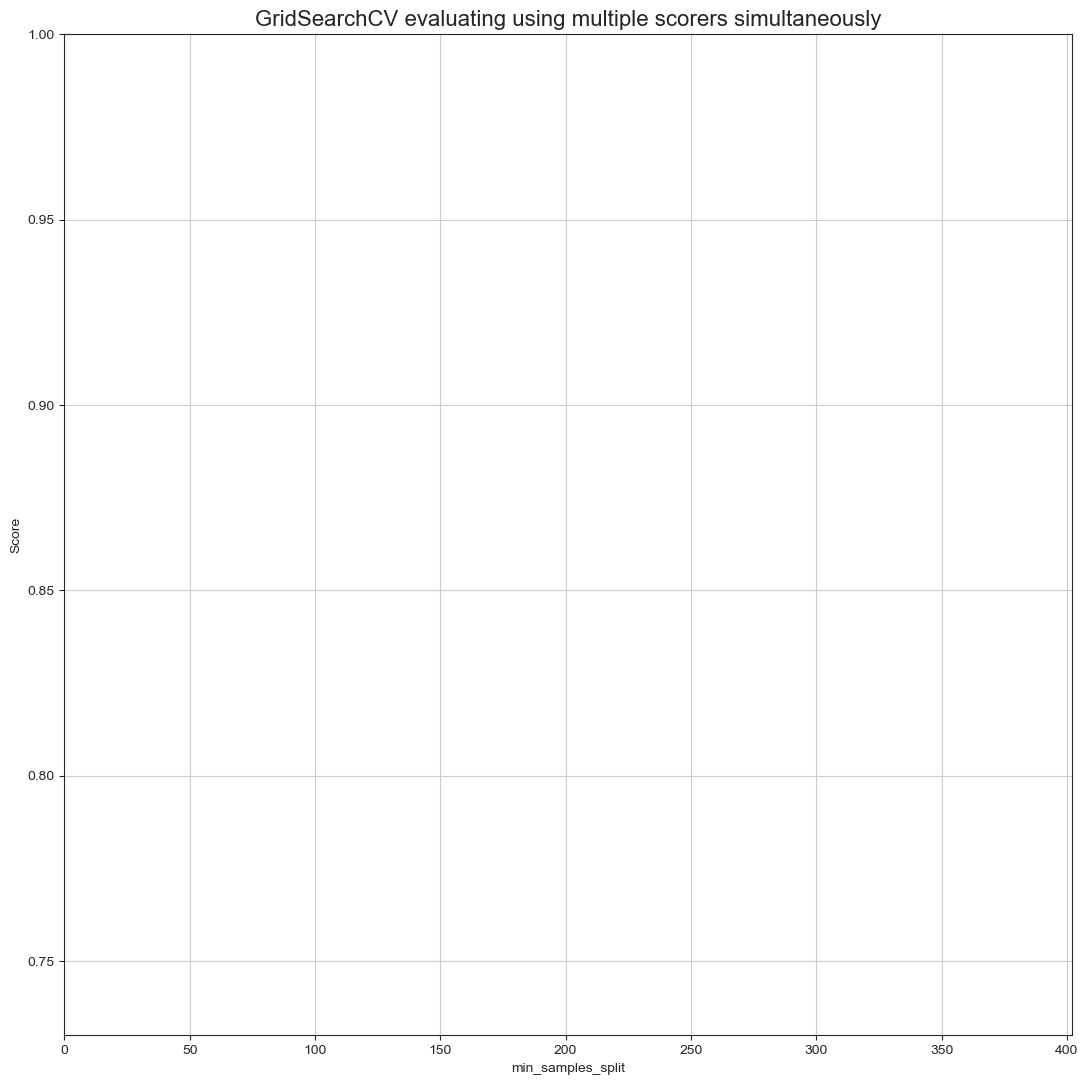

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(grid.cv_results_["param_classify__n_estimators"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k", "r"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
